In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
 
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime')
 
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.4.1
Running on TPU  ['10.25.227.42:8470']


INFO:tensorflow:Initializing the TPU system: grpc://10.25.227.42:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.25.227.42:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from math import log, sqrt, exp
import pandas as pd
import numpy as np
from numpy import sign

import re
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

from keras import optimizers
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D, Bidirectional, SimpleRNN
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
depressed_tweets = pd.read_csv('/content/drive/MyDrive/BTP-SEM4/datasets/depressed_tweets.csv', nrows = 150000)
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "tweet"]
random_tweets = pd.read_csv('/content/drive/MyDrive/BTP-SEM4/datasets/nondepressive/training.1600000.processed.noemoticon.csv', encoding = "ISO-8859-1", names = DATASET_COLUMNS)

In [ ]:
group = random_tweets.groupby(random_tweets.target)
random_tweets = group.get_group(4)
random_tweets = random_tweets[:150000]

random_tweets['label'] = [1]*150000
depressed_tweets['label'] = [0]*150000

random_tweets.drop(['target','ids','date','flag','user'], axis = 1, inplace = True)
depressed_tweets.drop(['Unnamed: 0','vader_score','vader_sentiment_label'], axis = 1, inplace = True)

df = pd.concat([random_tweets,depressed_tweets], ignore_index  =True)

TOKENIZATION


In [ ]:
from nltk.tokenize import TweetTokenizer
tk = TweetTokenizer(reduce_len=True)

data = []

X = df['tweet'].tolist()
Y = df['label'].tolist()

for x, y in zip(X, Y):
    if y == 1:
        data.append((tk.tokenize(x), 1))
    else:
        data.append((tk.tokenize(x), 0))
      


In [ ]:
import re, string


from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
STOP_WORDS = stopwords.words('english')

def cleaned(token):
    if token == 'u':
        return 'you'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow' or token == '2moro':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == '4got' or token == '4gotten':
        return 'forget'
    if token in ['hahah', 'hahaha', 'hahahaha']:
        return 'haha'
    if token == "mother's":
        return "mother"
    if token == "mom's":
        return "mom"
    if token == "dad's":
        return "dad"
    if token == 'bday' or token == 'b-day':
        return 'birthday'
    if token in ["i'm", "don't", "can't", "couldn't", "aren't", "wouldn't", "isn't", "didn't", "hadn't","doesn't", "won't", "haven't", "wasn't", "hasn't", "shouldn't", "ain't", "they've"]:
        return token.replace("'", "")
    if token in ['lmao', 'lolz', 'rofl']:
        return 'lol'
    if token == '<3':
        return 'love'
    if token == 'thanx' or token == 'thnx' or token == "thnks":
        return 'thanks'
    if token == 'goood':
        return 'good'
    if token in ['amp', 'quot', 'lt', 'gt', '½25', '..', '. .', '. . .']:
        return ''
    return token



def remove_noise(tweet_tokens):

    cleaned_tokens = []

    for token in tweet_tokens:
        
        token = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", token)
        
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        
        cleaned_token = cleaned(token.lower())
        
        if cleaned_token == "idk":
            cleaned_tokens.append('i')
            cleaned_tokens.append('dont')
            cleaned_tokens.append('know')
            continue
        if cleaned_token == "i'll":
            cleaned_tokens.append('i')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "you'll":
            cleaned_tokens.append('you')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "we'll":
            cleaned_tokens.append('we')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "it'll":
            cleaned_tokens.append('it')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "it's":
            cleaned_tokens.append('it')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "i've":
            cleaned_tokens.append('i')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "you've":
            cleaned_tokens.append('you')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "we've":
            cleaned_tokens.append('we')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "they've":
            cleaned_tokens.append('they')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "you're":
            cleaned_tokens.append('you')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "we're":
            cleaned_tokens.append('we')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "they're":
            cleaned_tokens.append('they')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "let's":
            cleaned_tokens.append('let')
            cleaned_tokens.append('us')
            continue
        if cleaned_token == "she's":
            cleaned_tokens.append('she')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "he's":
            cleaned_tokens.append('he')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "that's":
            cleaned_tokens.append('that')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "i'd":
            cleaned_tokens.append('i')
            cleaned_tokens.append('would')
            continue
        if cleaned_token == "you'd":
            cleaned_tokens.append('you')
            cleaned_tokens.append('would')
            continue
        if cleaned_token == "there's":
            cleaned_tokens.append('there')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "what's":
            cleaned_tokens.append('what')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "how's":
            cleaned_tokens.append('how')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "who's":
            cleaned_tokens.append('who')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "y'all" or cleaned_token == "ya'll":
            cleaned_tokens.append('you')
            cleaned_tokens.append('all')
            continue

        if cleaned_token.strip() and cleaned_token not in string.punctuation and len(cleaned_token)>2 and cleaned_token not in STOP_WORDS: 
            cleaned_tokens.append(cleaned_token)
            
    return cleaned_tokens


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/content/drive/MyDrive/BTP-SEM4/embeddings/glove.6B.300d.txt')

In [ ]:
unks = []
UNKS = []
 
def cleared(word):
    res = ""
    prev = None
    for char in word:
        if char == prev: continue
        prev = char
        res += char
    return res

def sentence_to_indices(sentence_words, word_to_index, max_len, i):
    global X, Y
    sentence_indices = []
    for j, w in enumerate(sentence_words):
        try:
            index = word_to_index[w]
        except:
            UNKS.append(w)
            w = cleared(w)
            try:
                index = word_to_index[w]
            except:
                index = word_to_index['unk']
                unks.append(w)
        X[i, j] = index

cleaned_tokens_list = []

for tokens, label in data:
    x = remove_noise(tokens)
    if x:
        cleaned_tokens_list.append((x, label))

list_len = [len(i) for i, j in cleaned_tokens_list]
max_len = max(list_len)
print('max_len:', max_len)

X = np.zeros((len(cleaned_tokens_list), max_len))
Y = np.zeros((len(cleaned_tokens_list), ))

for i, tk_lb in enumerate(cleaned_tokens_list):
    tokens, label = tk_lb
    sentence_to_indices(tokens, word_to_index, max_len, i)
    Y[i] = label
    

max_len: 49


In [ ]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len):
    vocab_len = len(word_to_index) + 1
    emb_dim = word_to_vec_map["unk"].shape[0] 
    
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]
        
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False, input_shape=(max_len,))
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

### LSTM

In [ ]:
def model():
  
  model = Sequential()
  model.add(pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len))
  model.add(LSTM(units=16, return_sequences=False))
  model.add(Dropout(0.5))
  model.add(Dense(units=1, activation='sigmoid'))

  return model

In [ ]:
with tpu_strategy.scope():
  model = model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 49, 300)           120000300 
_________________________________________________________________
lstm_6 (LSTM)                (None, 16)                20288     
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 120,020,605
Trainable params: 20,305
Non-trainable params: 120,000,300
_________________________________________________________________


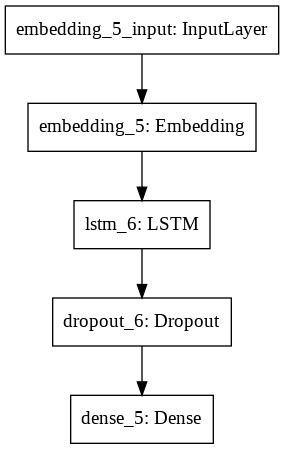

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
nadam = optimizers.Nadam(lr=0.0001,
                         beta_1=0.9,
                         beta_2=0.999,
                         epsilon=1e-8, 
                         schedule_decay=0.004)
model.compile(loss='binary_crossentropy',
              optimizer=nadam,
              metrics=['acc'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience=3)
history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val), 
                    epochs = 20,
                    batch_size = 128,
                    shuffle=True,
                    callbacks = [early_stop])


Epoch 1/20
1388/1388 [==============================] - 43s 27ms/step - loss: 0.4805 - acc: 0.7603 - val_loss: 0.2106 - val_acc: 0.9425
Epoch 2/20
1388/1388 [==============================] - 34s 25ms/step - loss: 0.2269 - acc: 0.9448 - val_loss: 0.1899 - val_acc: 0.9478
Epoch 3/20
1388/1388 [==============================] - 34s 25ms/step - loss: 0.2054 - acc: 0.9496 - val_loss: 0.1751 - val_acc: 0.9498
Epoch 4/20
1388/1388 [==============================] - 34s 25ms/step - loss: 0.1847 - acc: 0.9531 - val_loss: 0.1646 - val_acc: 0.9520
Epoch 5/20
1388/1388 [==============================] - 34s 25ms/step - loss: 0.1671 - acc: 0.9567 - val_loss: 0.1495 - val_acc: 0.9535
Epoch 6/20
1388/1388 [==============================] - 34s 25ms/step - loss: 0.1543 - acc: 0.9560 - val_loss: 0.1355 - val_acc: 0.9549
Epoch 7/20
1388/1388 [==============================] - 34s 25ms/step - loss: 0.1378 - acc: 0.9577 - val_loss: 0.1269 - val_acc: 0.9567
Epoch 8/20
1388/1388 [==========================

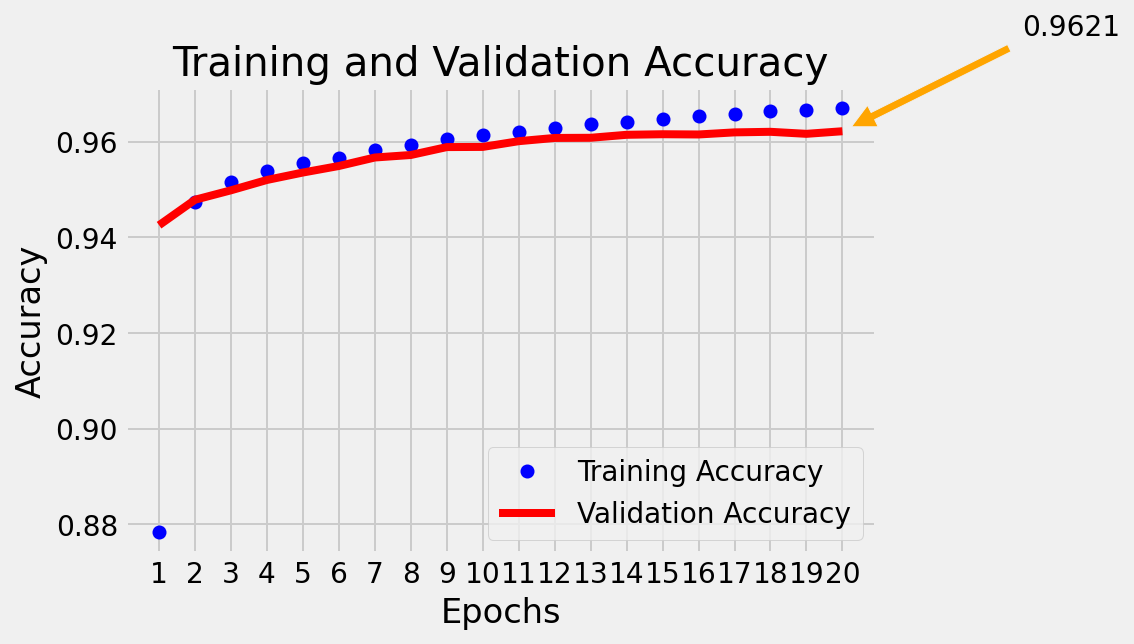

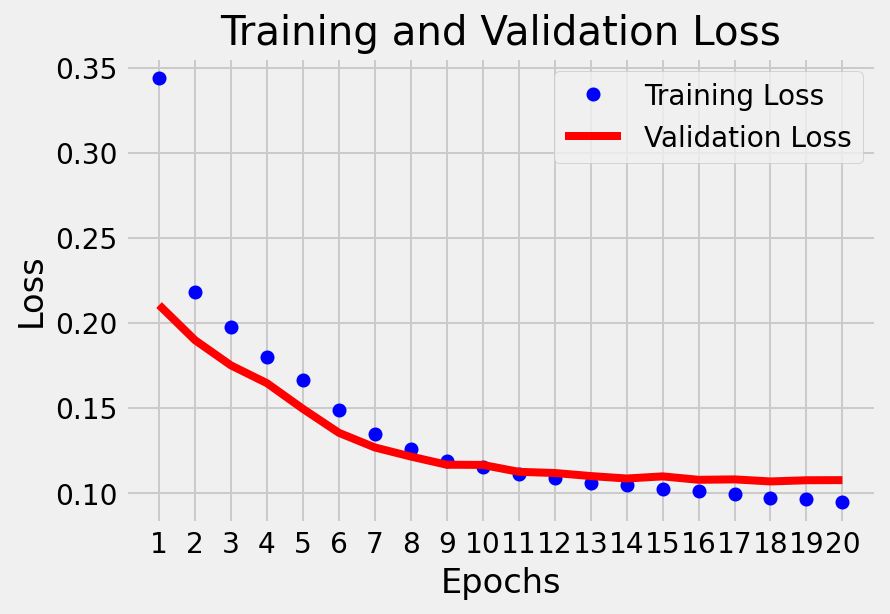

In [ ]:
history = model.history

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
y_arrow = max(val_acc)
x_arrow = val_acc.index(y_arrow) + 1
plt.annotate(str(y_arrow)[:6],
             (x_arrow, y_arrow),
             xytext=(x_arrow + 5, y_arrow + .02),
             arrowprops=dict(facecolor='orange', shrink=0.05))
plt.xticks(epochs)

plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred.flatten())
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.95      0.96     29314
         1.0       0.95      0.98      0.97     29877

    accuracy                           0.96     59191
   macro avg       0.96      0.96      0.96     59191
weighted avg       0.96      0.96      0.96     59191



In [ ]:
score = model.evaluate(X_test, y_test)

1850/1850 [==============================] - 35s 19ms/step - loss: 0.1031 - acc: 0.9641
